In [25]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import datetime as dt
from datetime import timedelta, date

from sklearn.preprocessing import MinMaxScaler
import joblib

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/arima_data_unscaled.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

#Wahre Werte der Testdaten
y_true = df_unscaled["verbrauch"]["2021-01-01":]

#Kalender laden
df_calendar = pd.read_csv("../2-Data Understanding/Datenbeschaffung/kalender.csv", index_col=0, parse_dates=True)

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/arima_data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag", "temperatur"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag", "temperatur"]]["2021-01-01":]

exog = exog_train.append(exog_test)

endog_train = df_scaled["verbrauch"][:"2020-12-31"]
endog_test = df_scaled["verbrauch"]["2021-01-01":]

endog = endog_train.append(endog_test)

# <font size="7">Analyse der besonders großen Abweichungen</font>

<font size="5">Das ARIMA(2,0,2)(2,0,2)7 [Arbeitstag, Temperatur] hat große Probleme an und nach Feiertagen. Ziel ist es, diese Abweichungen durch weitere Merkmale zu verringern.</font>

## <font size="6">ARIMA(2,0,2)(2,0,2)7 [Arbeitstag, Temperatur]</font>

In [3]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4556.901
Date:                           Thu, 03 Feb 2022   AIC                          -9091.801
Time:                                   22:26:17   BIC                          -9027.489
Sample:                               01-01-2015   HQIC                         -9068.479
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2951      0.002    151.520      0.000       0.291       0.299
temperatur    -0.0734      0.014     -5.418

      Vorhersage
R2          0.96
MAE       3613.0
MSE   26901261.0
RMSE      5187.0
                
MAPE       2.1 %


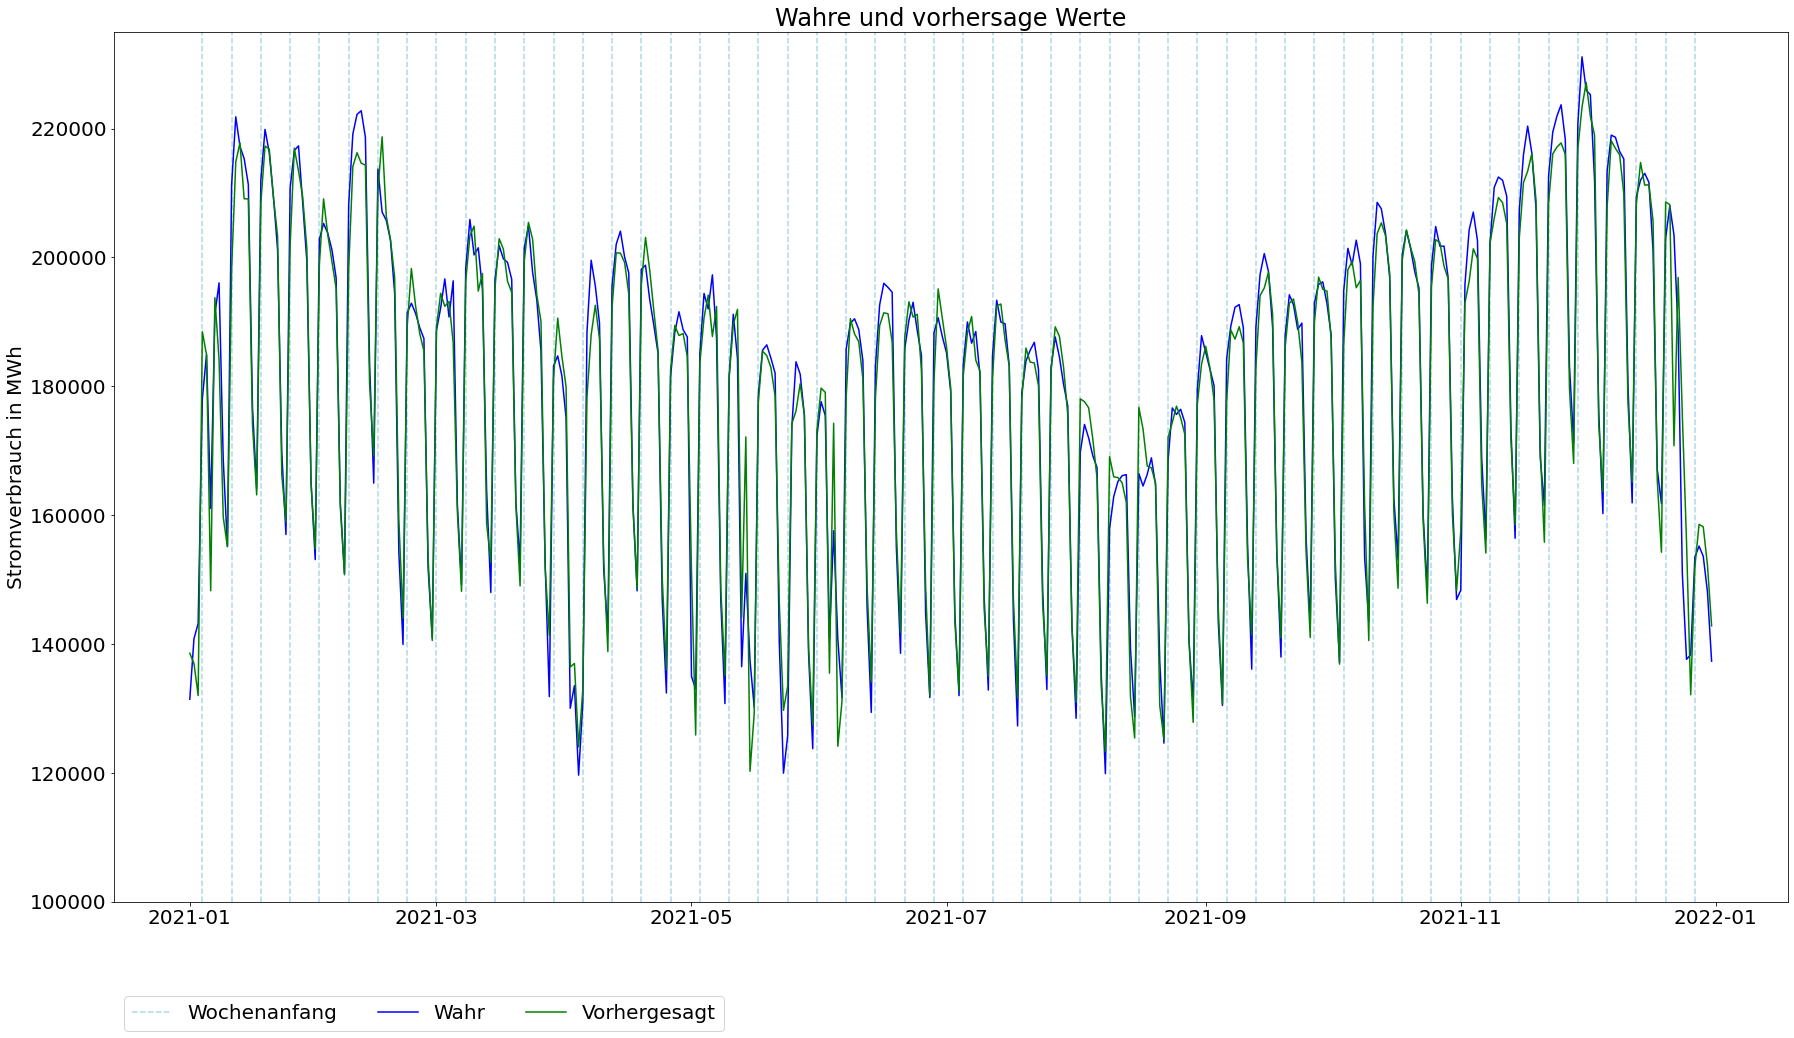

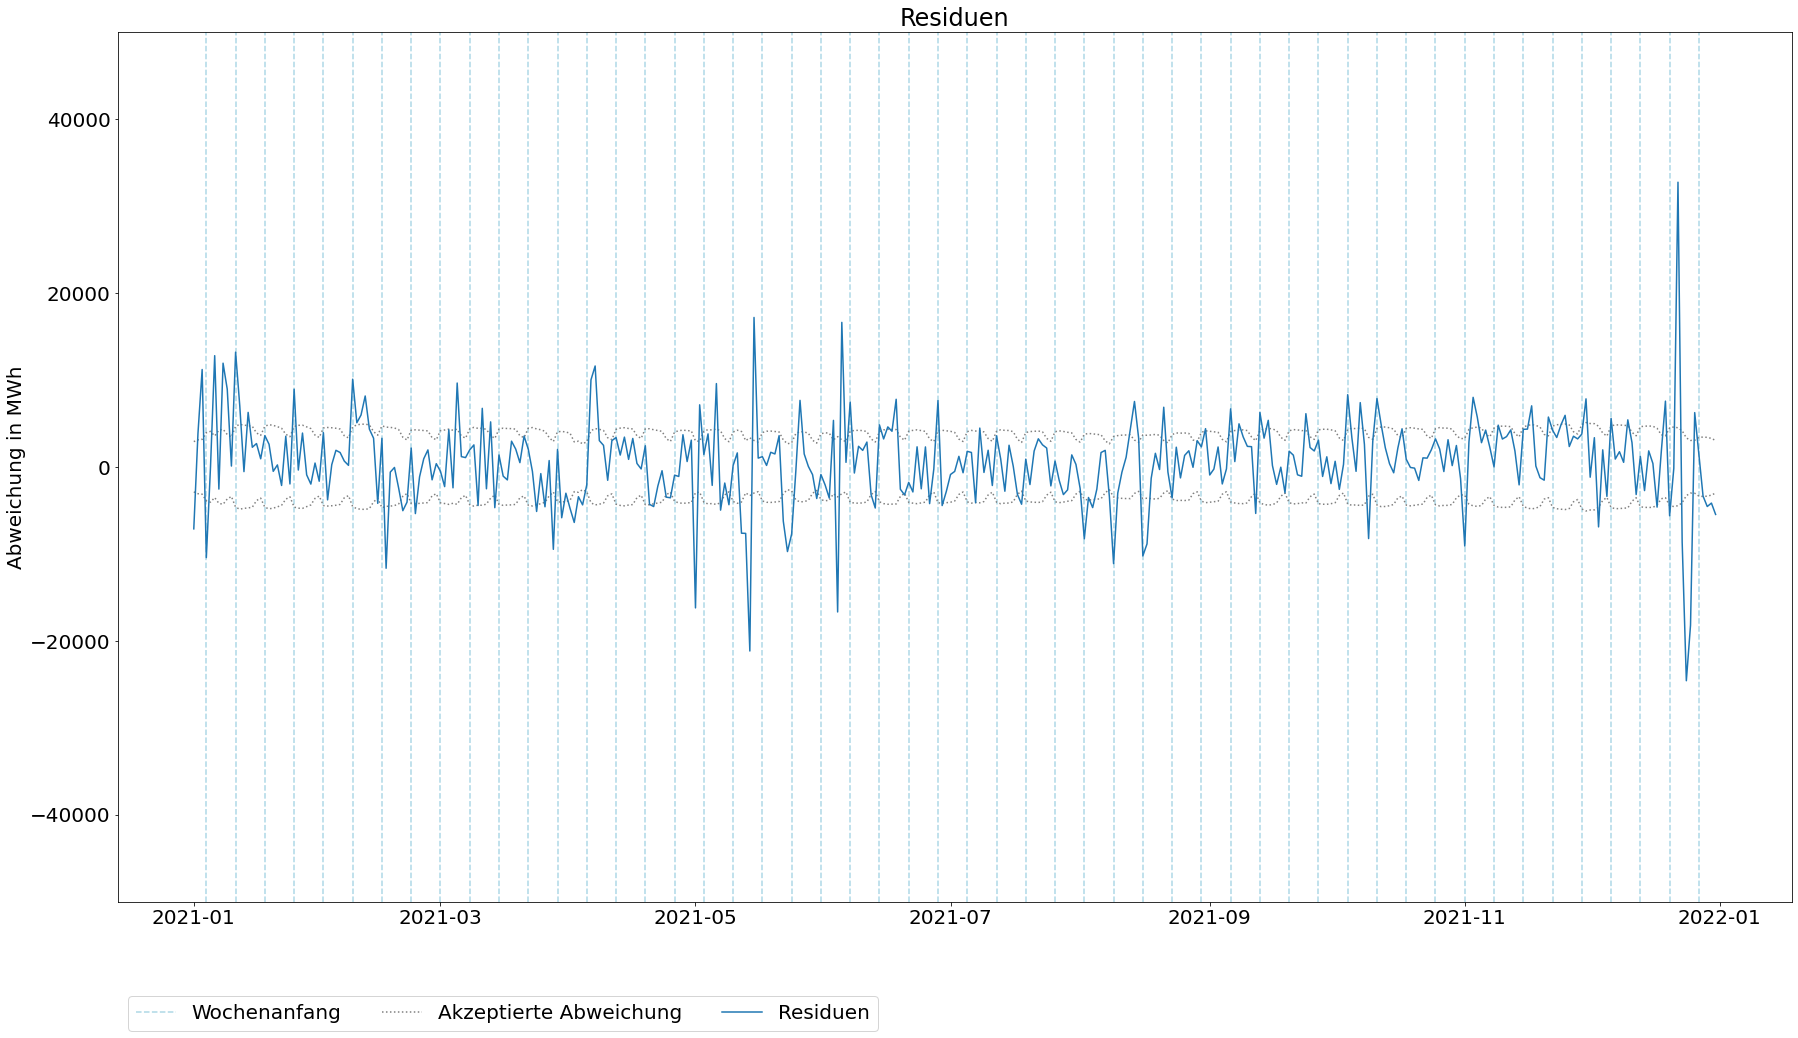

In [4]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, residuals=True)

## <font size="6">Große Abweichungen an und um Feiertage</font><a class="anchor" id="4-02d-feiertage"></a>

<font size="5">An Feiertagen ist der Stromverbrauch außergewöhnlich niedrig und die wöchentliche Saisonalität wird unterbrochen. Dennoch handelt es sich nicht um Ausreißer im klassischen (rein mathematischen) Sinne, da die Abweichung einer gewissen Systematik folgen. Außerdem hat das Modell nicht nur Probleme an Feiertagen selbst, sondern auch unmittelbar danach. Wenn die außergewöhnlich niedrigen Stromverbräuche als Eingangsvariablen für die Regressionsgleichung folgender Tage verwendet werden, verzerrt sich auch die Vorhersage für folgende Tage. Dadurch kommt es zu starken Abweichungen an einem, zwei, sieben und vierzehn Tagen nach einem Feiertag.</font>

### <font size="5">An Feiertagen</font>

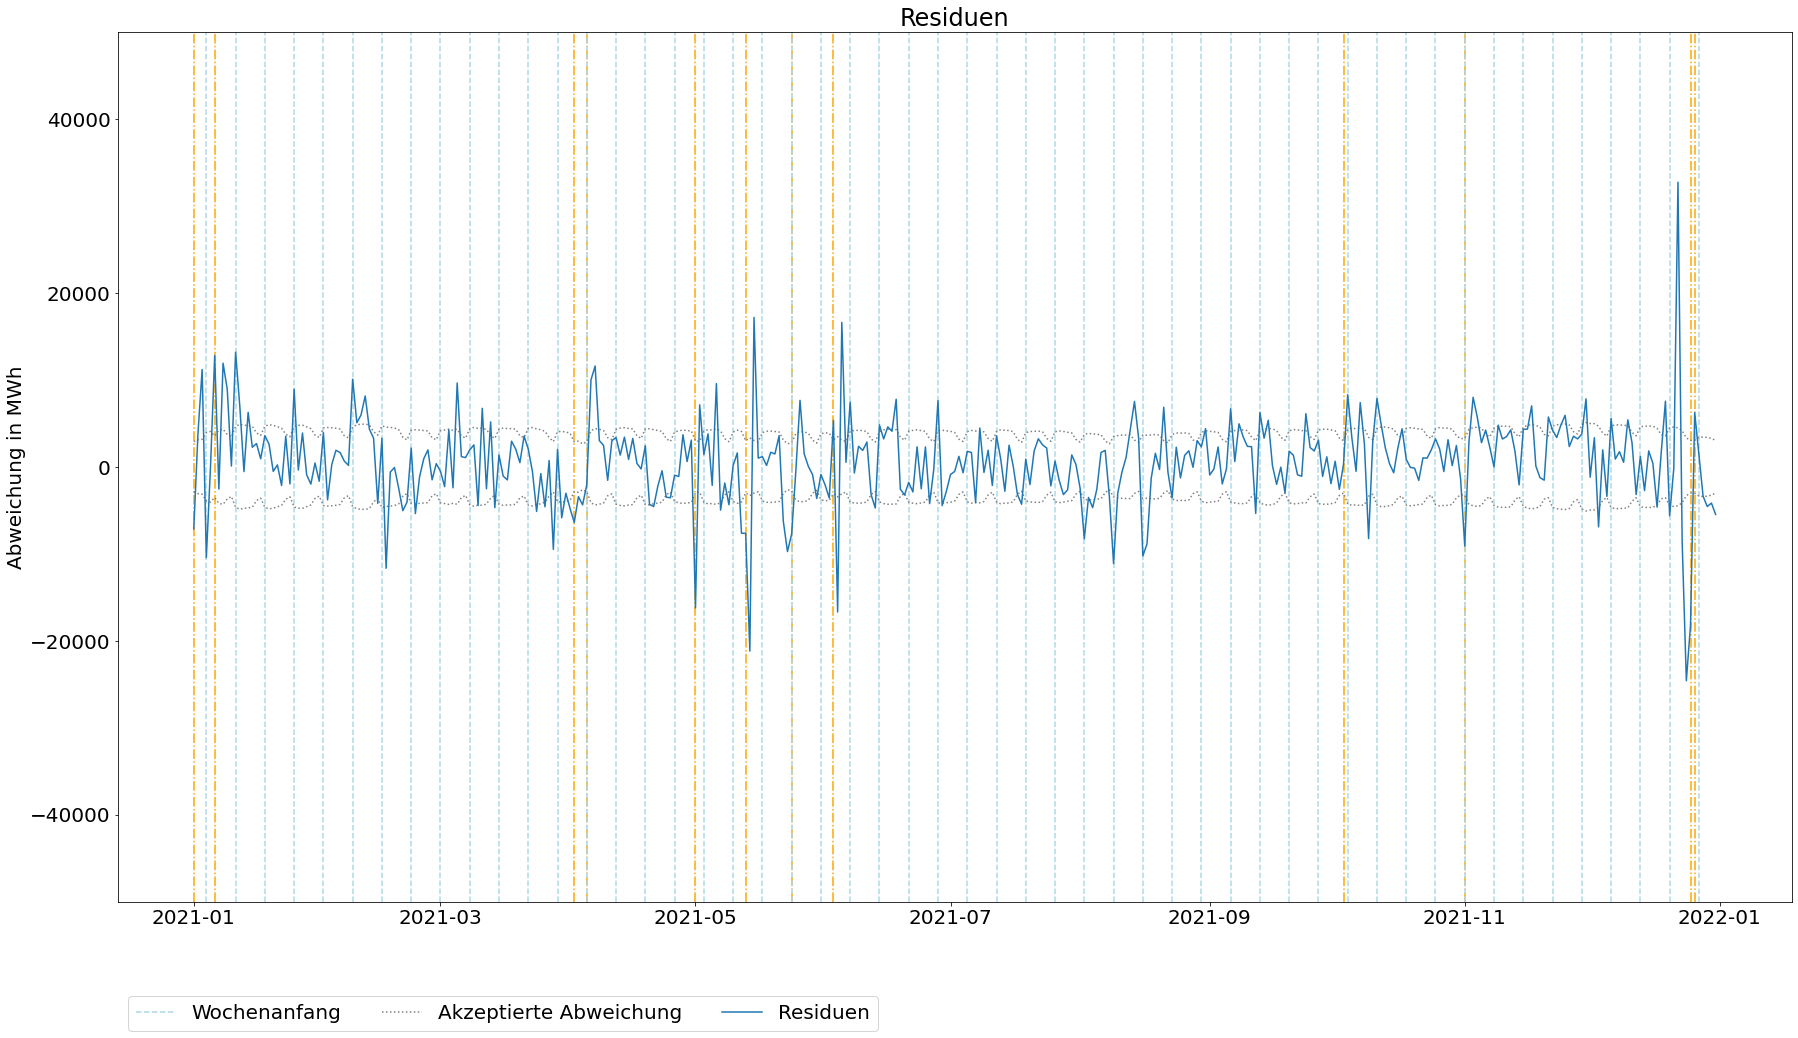

In [5]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, False, False, True, False)

### <font size="5">Am ersten Tag nach Feiertagen</font>

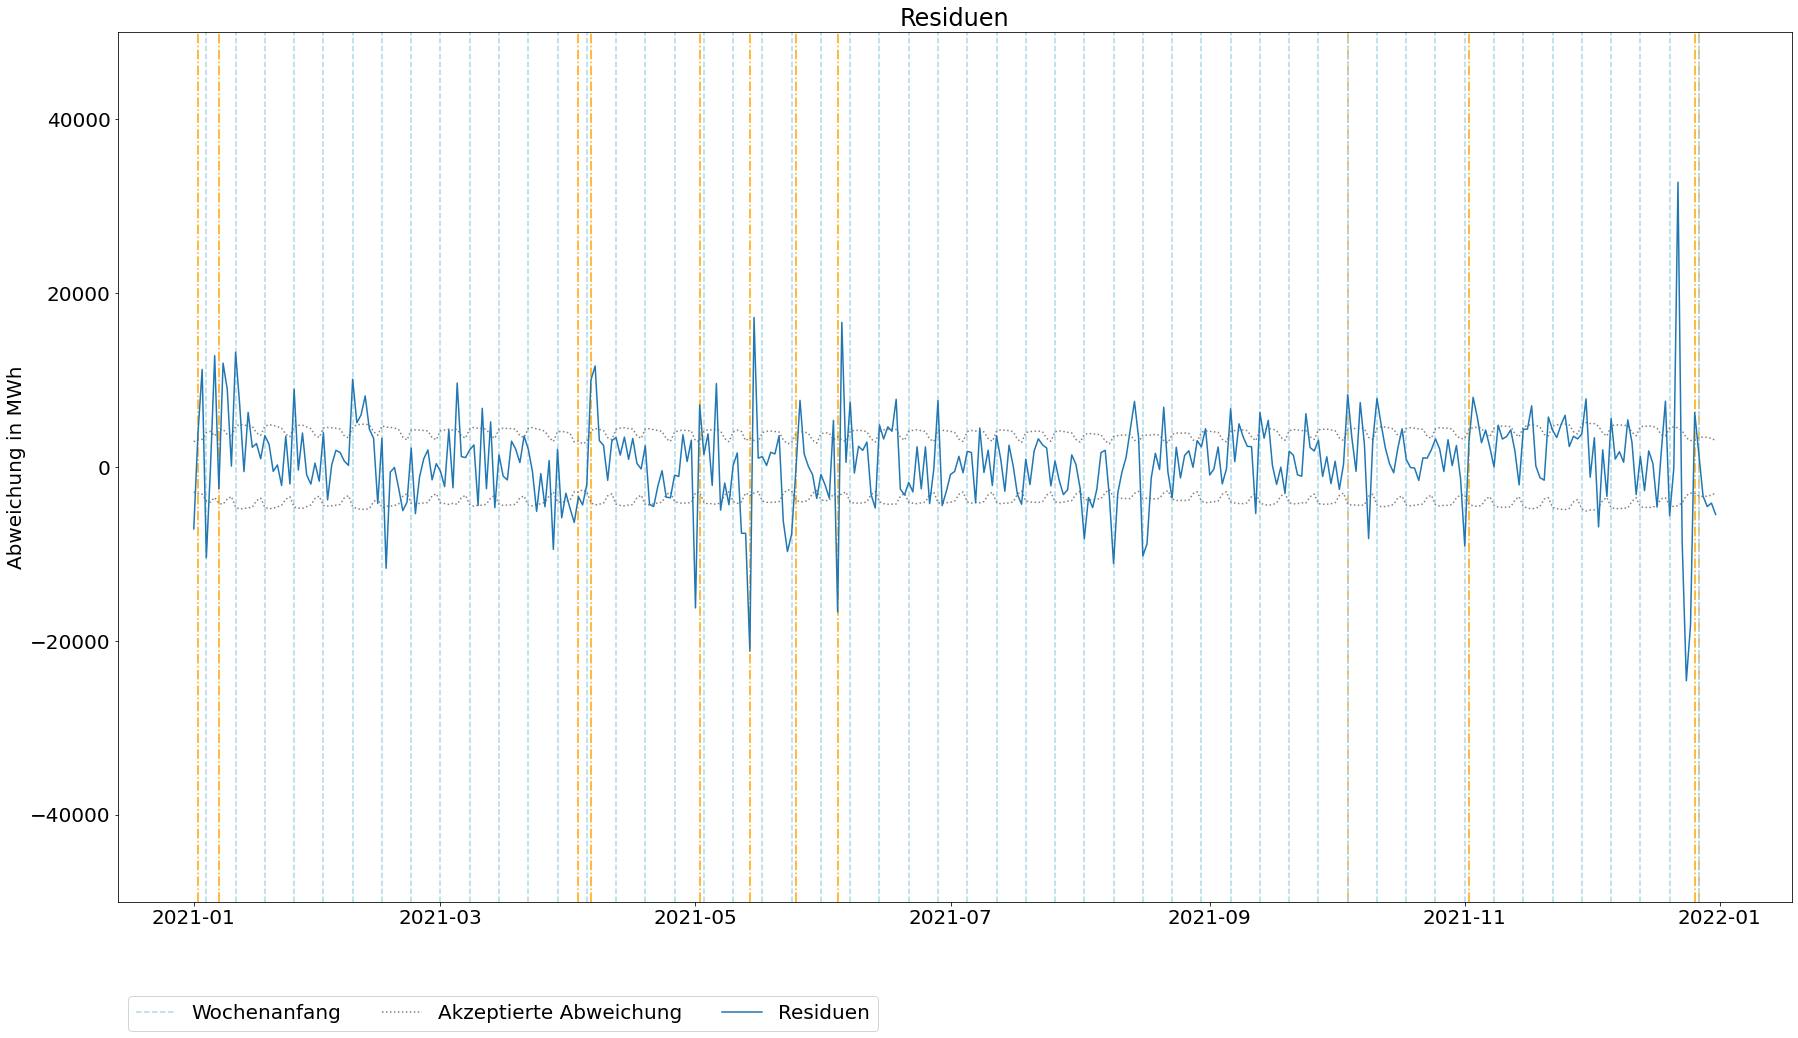

In [6]:
#Ersten Tag nach Feiertagen einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date + timedelta(days=1), ymin=0, ymax=1, color="orange", linestyle="-.")
    
#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, False, False, True, False)

### <font size="5">Am zweiten Tag nach Feiertagen</font>

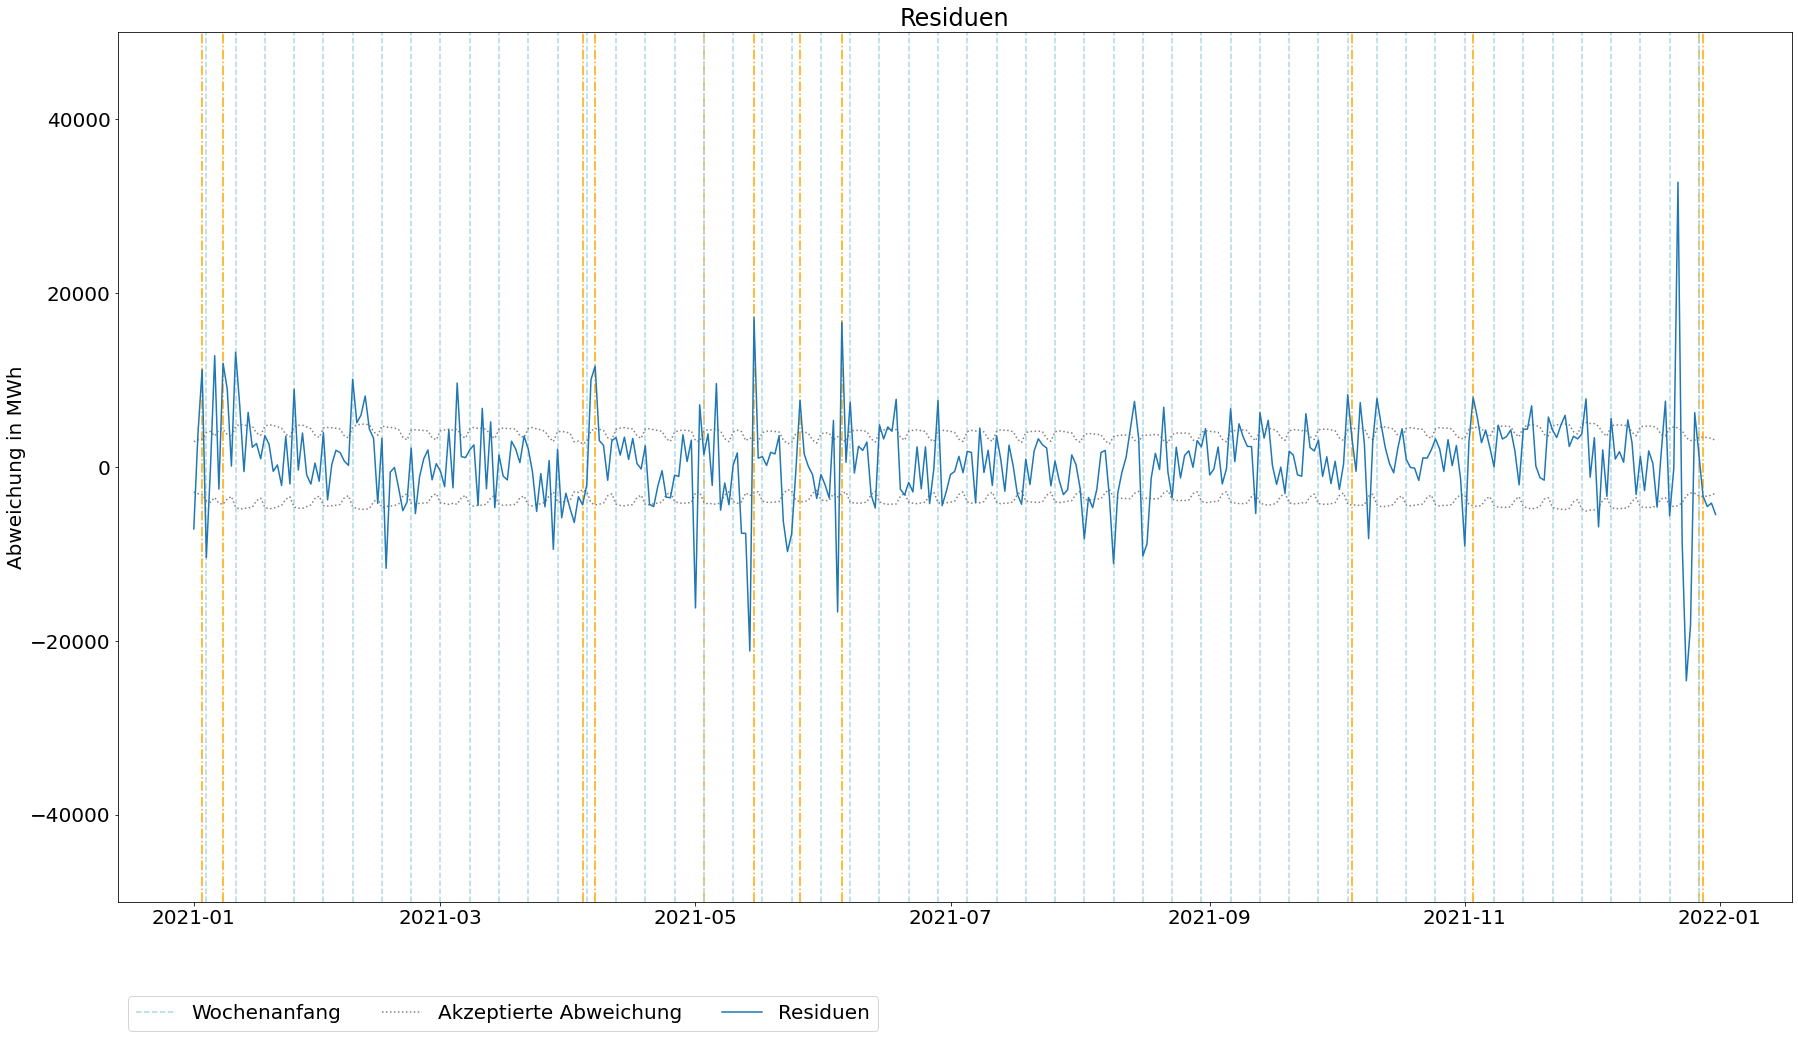

In [7]:
#Zweiten Tag nach Feiertagen einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date + timedelta(days=2), ymin=0, ymax=1, color="orange", linestyle="-.")
    
#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, False, False, True, False)

### <font size="5">Am siebten Tag nach Feiertagen</font>

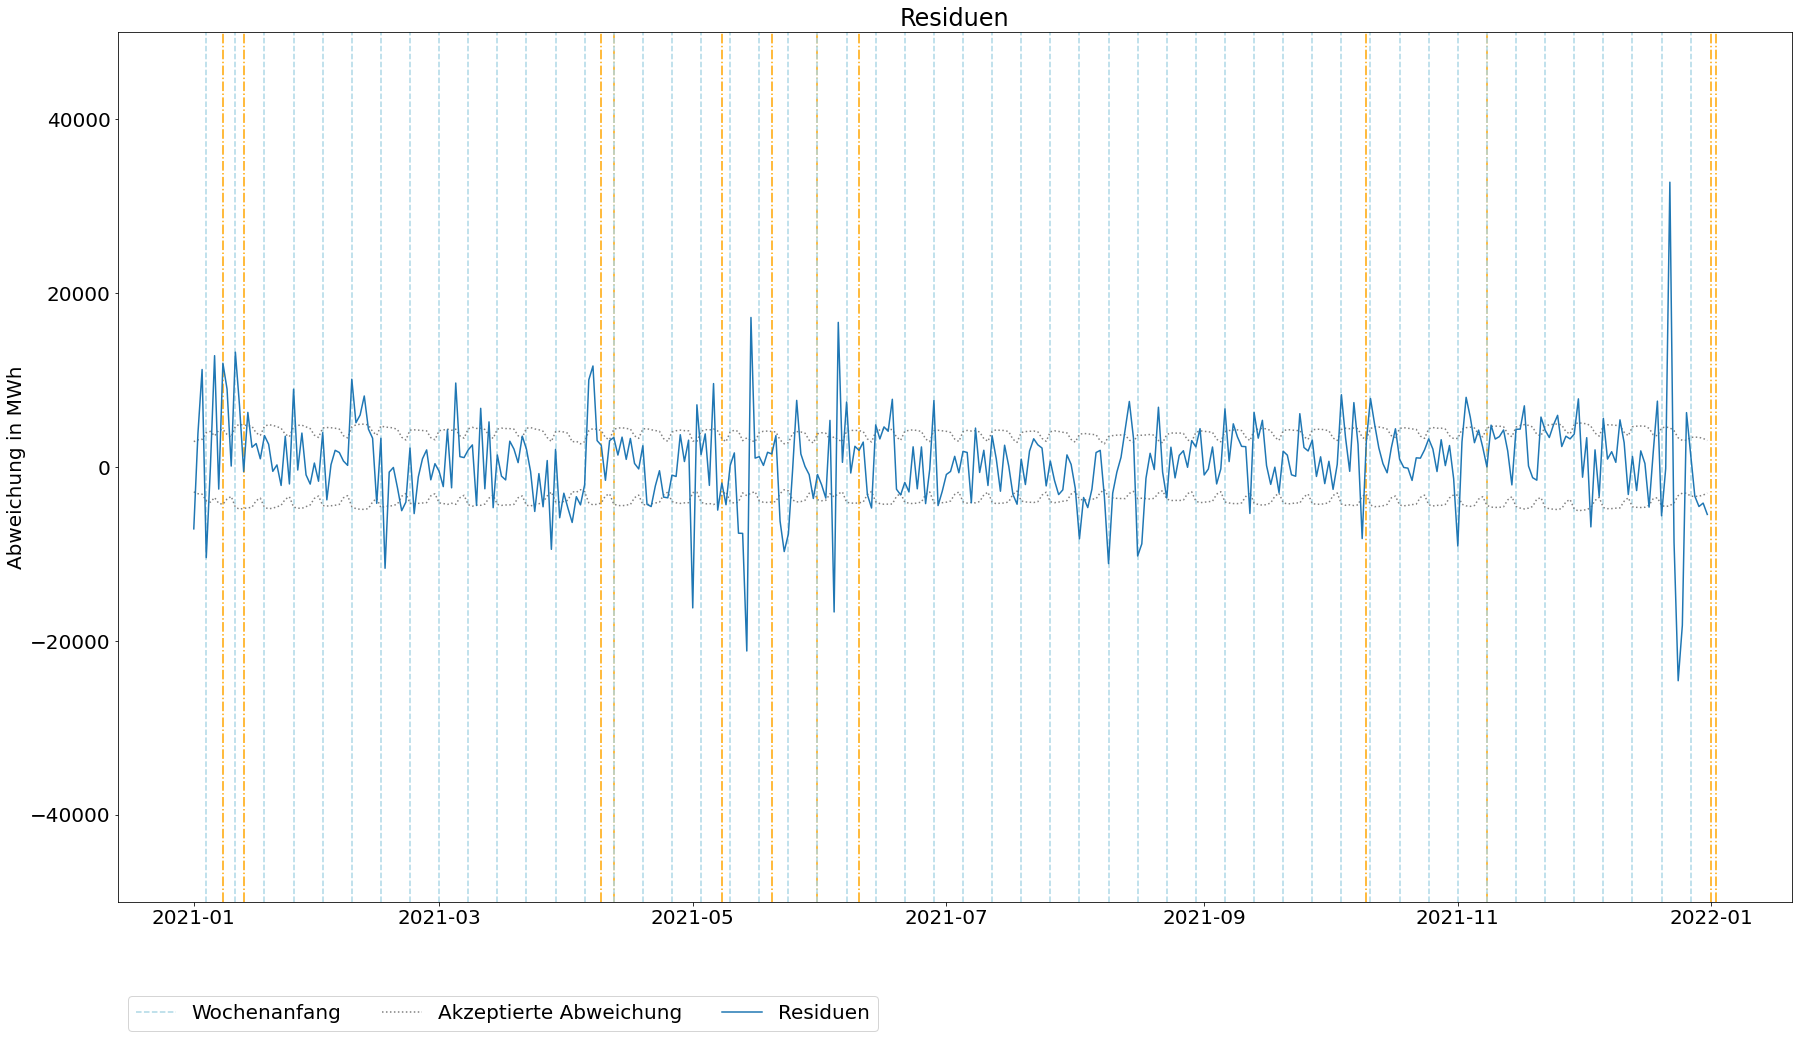

In [8]:
#Woche nach Feiertagen einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date + timedelta(days=7), ymin=0, ymax=1, color="orange", linestyle="-.")
    
#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, False, False, True, False)

### <font size="5">Am vierzehnten Tag nach Feiertagen</font>

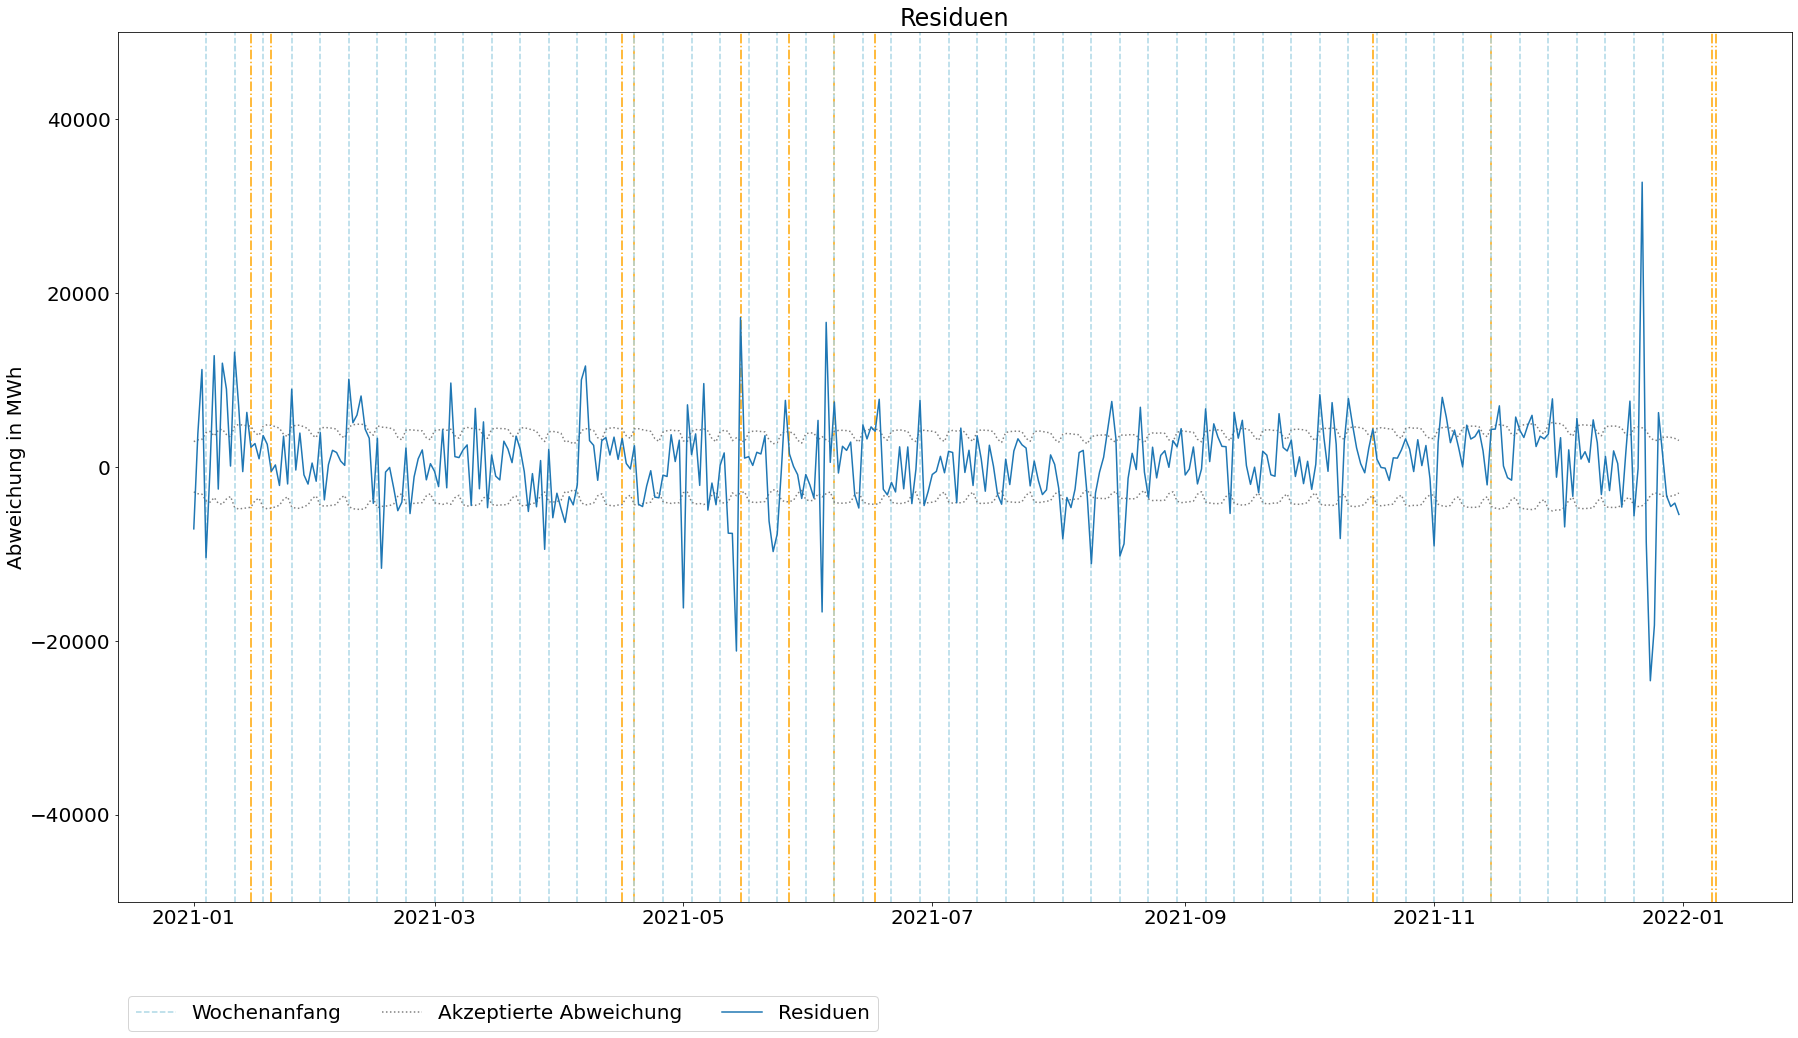

In [9]:
#Zwei Wochen nach Feiertagen einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date + timedelta(days=14), ymin=0, ymax=1, color="orange", linestyle="-.")
    
#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, False, False, True, False)

# <font size="7">Verbesserung durch Merkmal für Feiertage</font><a class="anchor" id="4-02d-merkmale"></a>

<font size="5">Es soll im Folgenden versucht werden, diese Abweichungen durch Ausgleichskoeffizienten zu kompensieren.</font>

## <font size="6">Verbesserung durch Merkmal für Feiertage</font>

<font size="5">Dafür wird zunächst ein Indikator für Feiertage eingefügt. Dadurch lässt sich allerdings keine Verbesserung erzielen. Die Abweichung an und um die Feiertage herum wird dadurch allerdings kaum reduziert. Insgesamt verbessert sich der MAPE nicht. Allerdings hat sich das Modell sehr viel besser an die Trainingsdaten angepasst, die Log-Likelihood steigt auf 4.644 and und das AIC fällt auf -9.264. Es kann hier also von einer leichten Überanpassung ausgegangen werden. Der MAPE verbessert sich sehr wahrscheinlich deshalb nicht, weil das Modell Feiertage selbst bisher relativ gut erkennen konnte. Das Problem ergibt sich eher aus den Feiertagen als Eingabeparameter für die Vorhersage weiterer Tage.</font>

In [10]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/arima_data_unscaled.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

#Wahre Werte der Testdaten
y_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/arima_data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Exogene Daten um Feiertag erweitern
df_scaled["feiertag"] = df_calendar["feiertag"].notna().astype(int)

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag", "temperatur","feiertag"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag", "temperatur","feiertag"]]["2021-01-01":]

exog = exog_train.append(exog_test)

endog_train = df_scaled["verbrauch"][:"2020-12-31"]
endog_test = df_scaled["verbrauch"]["2021-01-01":]

endog = endog_train.append(endog_test)

In [11]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4643.945
Date:                           Thu, 03 Feb 2022   AIC                          -9263.891
Time:                                   22:26:29   BIC                          -9193.732
Sample:                               01-01-2015   HQIC                         -9238.449
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2395      0.003     83.391      0.000       0.234       0.245
temperatur    -0.0517      0.012     -4.173

      Vorhersage
R2          0.96
MAE       3613.0
MSE   26901261.0
RMSE      5187.0
                
MAPE       2.1 %


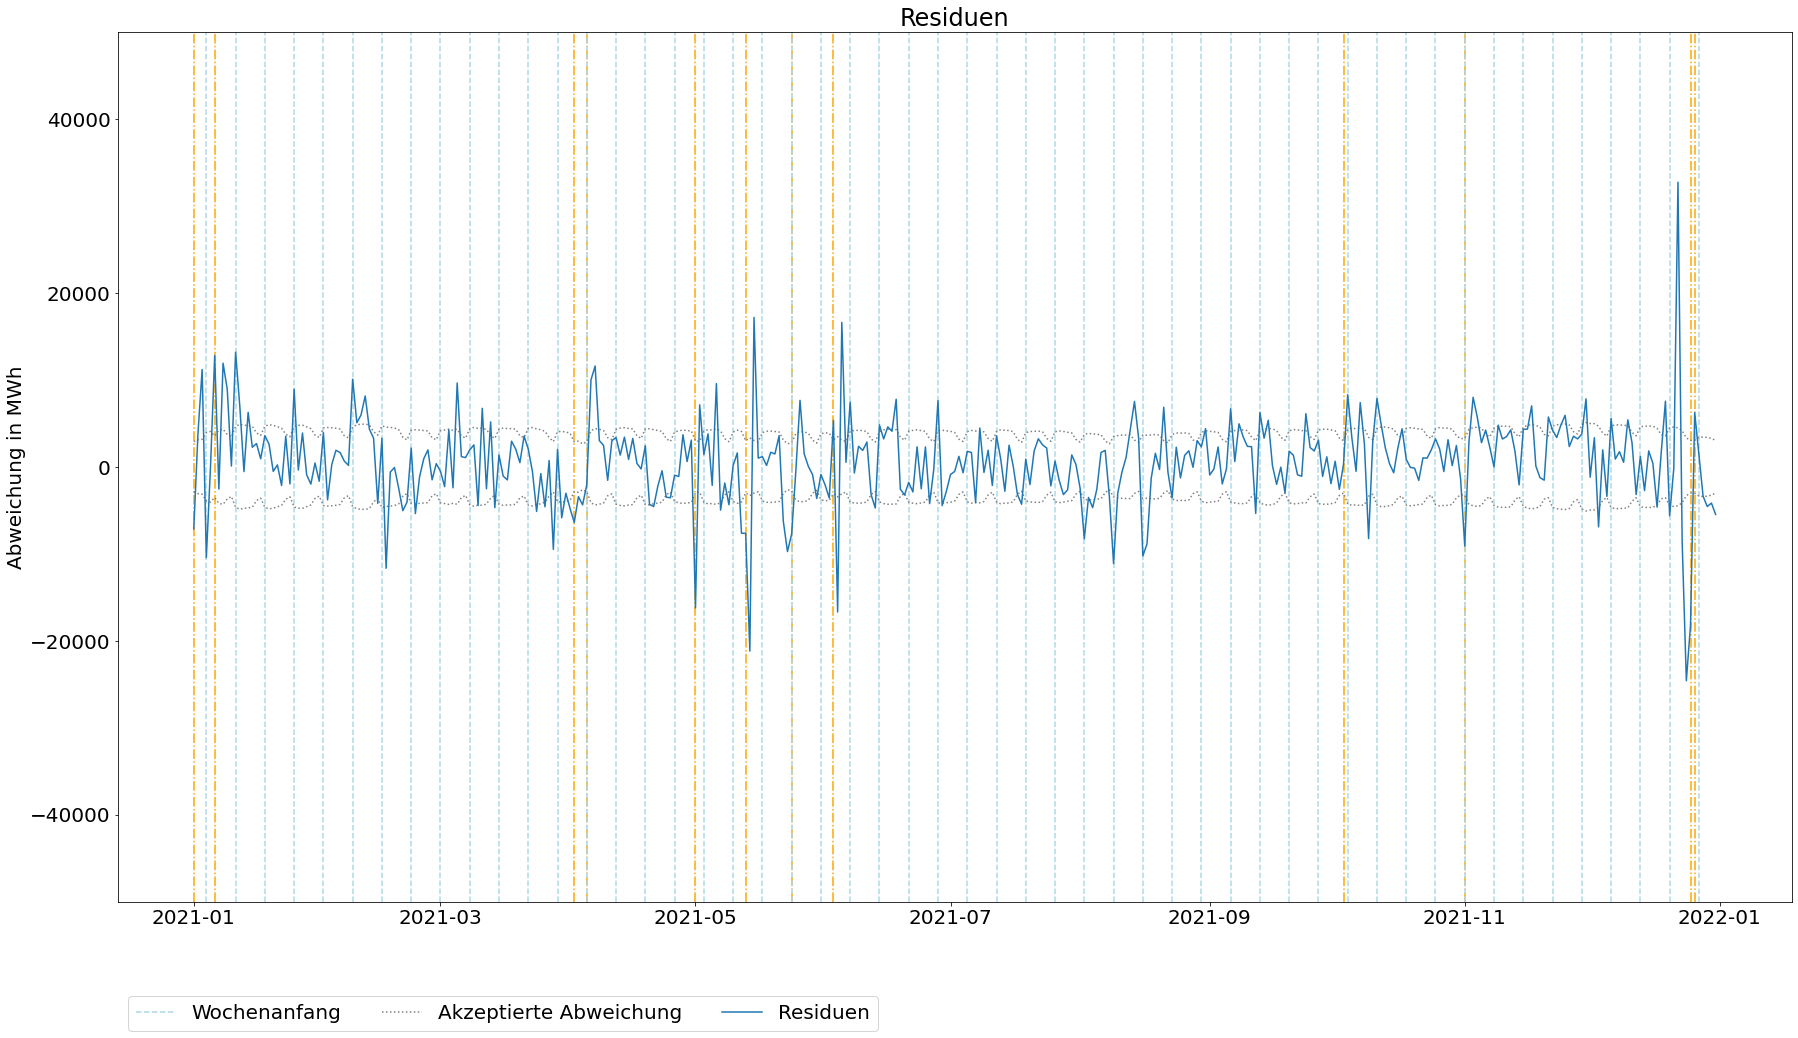

In [12]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, True, False, True, False)

## <font size="6">Verbesserung durch Merkmal für vergangene Feiertage (1)</font>

<font size="5">Es wird nun der erste Ausgleichskoeffizient für Feiertage eingefügt. Das zugrunde liegende Merkmal wird an Tagen nach einem Feiertag auf 1 gesetzt. Der dafür im ARIMA-Modell enthaltene Koeffizient soll den geringeren Verbrauch von Feiertagen ausgleichen. Dadurch verbessert sich das Modell auf den ersten Blick, da MAPE, Log-Likelihood und AIC etwas besser sind. Es handelt sich hierbei aber vermutlich um eine Überanpassung. Wie im Modell davor und im nächsten Modell erkennbar, führen beide Merkmale einzeln zu keiner Verbesserung.</font>

In [13]:
#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Arbeitsfreie Tage erweitern
df_scaled["urlaubssaison"] = pd.read_csv("Daten/urlaubssaison_1.csv", index_col=0, parse_dates=True)
df_scaled.loc[df_scaled["urlaubssaison"] == 1, 'arbeitstag'] = 0

#Exogene Daten um Feiertag und Tag danach erweitern
df_scaled["feiertag"] = df_calendar["feiertag"].notna().astype(int)
df_scaled["feiertag_1"] = df_scaled["feiertag"].shift(1).fillna(0)

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1"]]["2021-01-01":]

exog = exog_train.append(exog_test)

In [14]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False)

#Vorhersage invers-skalieren
scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")
preds = pd.DataFrame(data=scaler_target.inverse_transform(scaled_preds.values.reshape(-1, 1)), columns=["vorhergesagt"], index=pd.date_range('01/01/2021', periods=365, freq='D')).squeeze()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4670.613
Date:                           Thu, 03 Feb 2022   AIC                          -9315.227
Time:                                   22:26:40   BIC                          -9239.221
Sample:                               01-01-2015   HQIC                         -9287.665
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2092      0.002     95.737      0.000       0.205       0.213
temperatur    -0.0435      0.012     -3.485

      Vorhersage
R2           1.0
MAE       3453.4
MSE   25427227.3
RMSE      5042.5
                
MAPE       2.0 %


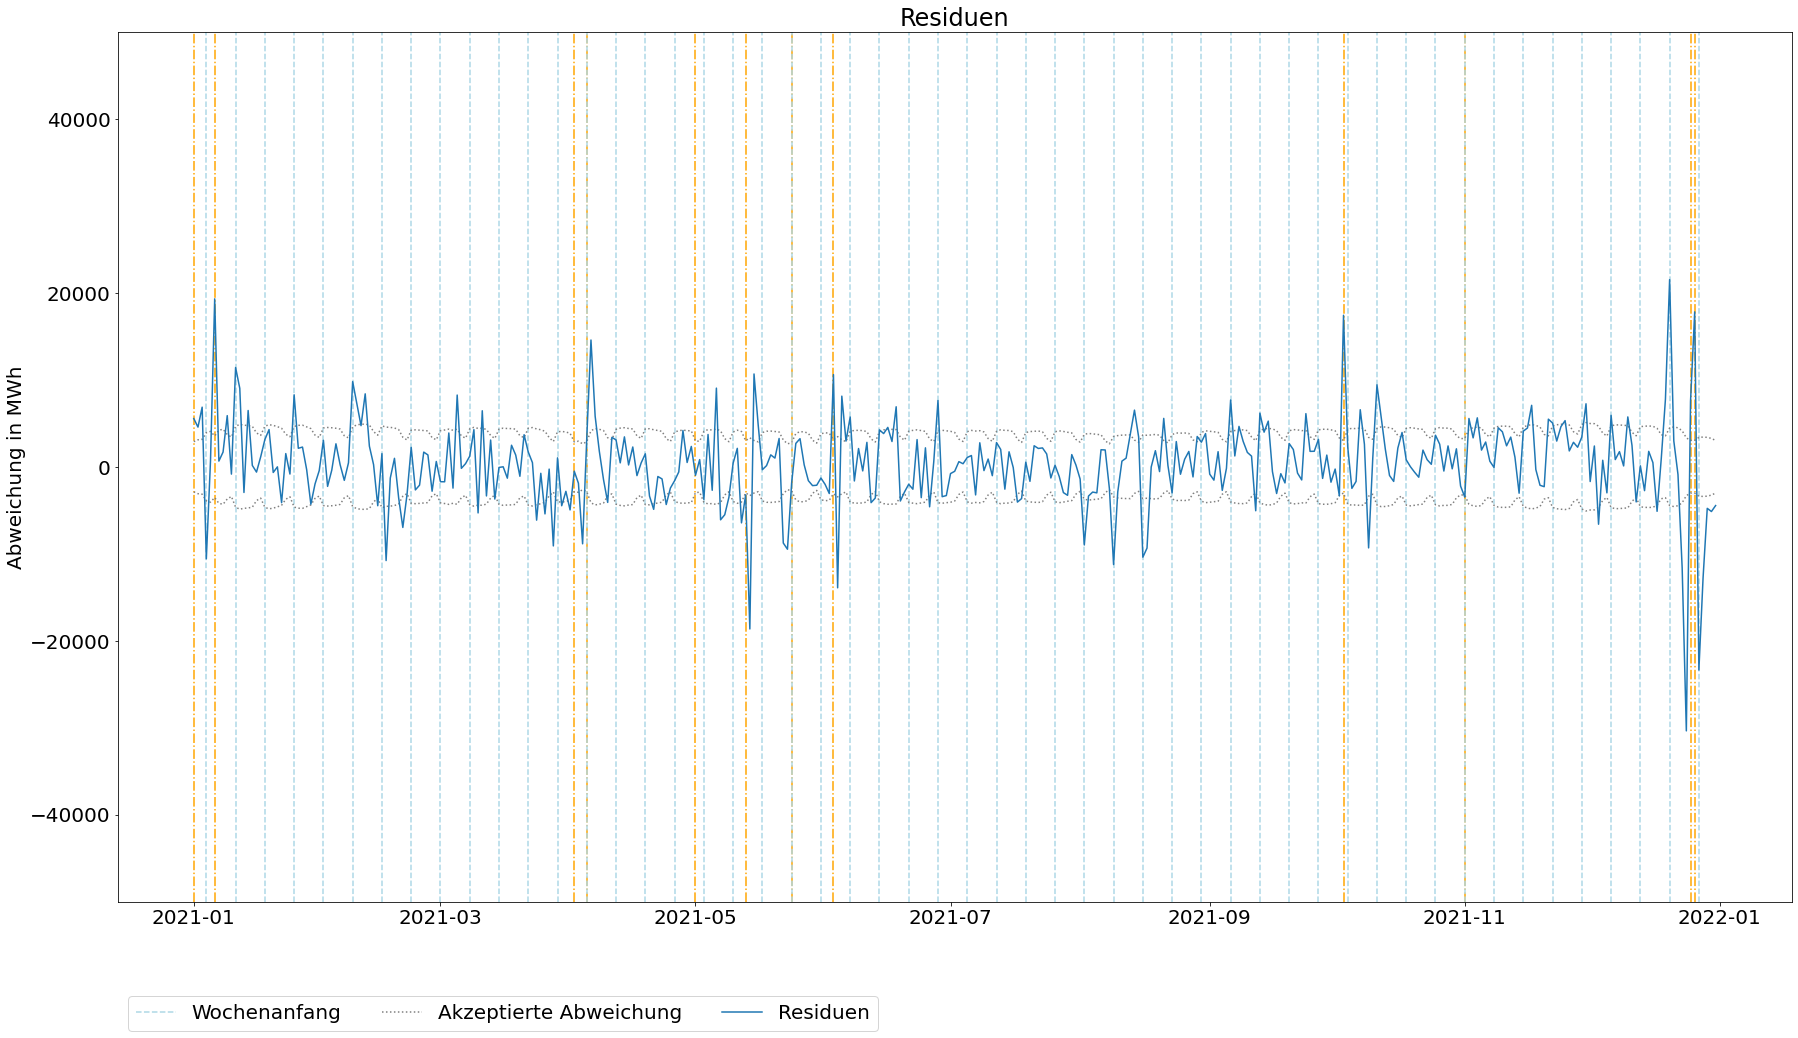

In [15]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics(y_true, preds, True, False, True, False)

## <font size="6">Verbesserung durch Merkmal für vergangene Feiertage (nur 1)</font>

<font size="5">In diesem Modell wird nur der Indikator für vergangene Feiertage (ohne den Indikator für Feiertage selbst) verwendet. Das Modell lässt sich dadurch allerdings nicht verbessern. Es ist also davon auszugehen, dass sich der Effekt der einzelnen Merkmale in Grenzen hält.</font>

In [27]:
#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Arbeitsfreie Tage erweitern
df_scaled["urlaubssaison"] = pd.read_csv("Daten/urlaubssaison_1.csv", index_col=0, parse_dates=True)
df_scaled.loc[df_scaled["urlaubssaison"] == 1, 'arbeitstag'] = 0

#Exogene Daten um Feiertag und Tag danach erweitern
df_scaled["feiertag"] = df_calendar["feiertag"].notna().astype(int)
df_scaled["feiertag_1"] = df_scaled["feiertag"].shift(1).fillna(0)

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag","temperatur","feiertag_1"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag","temperatur","feiertag_1"]]["2021-01-01":]

exog = exog_train.append(exog_test)

In [29]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False)

#Vorhersage invers-skalieren
scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")
preds = pd.DataFrame(data=scaler_target.inverse_transform(scaled_preds.values.reshape(-1, 1)), columns=["vorhergesagt"], index=pd.date_range('01/01/2021', periods=365, freq='D')).squeeze()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4413.317
Date:                           Thu, 03 Feb 2022   AIC                          -8802.634
Time:                                   22:32:29   BIC                          -8732.475
Sample:                               01-01-2015   HQIC                         -8777.192
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.3025      0.002    137.760      0.000       0.298       0.307
temperatur    -0.0618      0.014     -4.359

      Vorhersage
R2           1.0
MAE       3559.7
MSE   26741693.1
RMSE      5171.2
                
MAPE       2.1 %


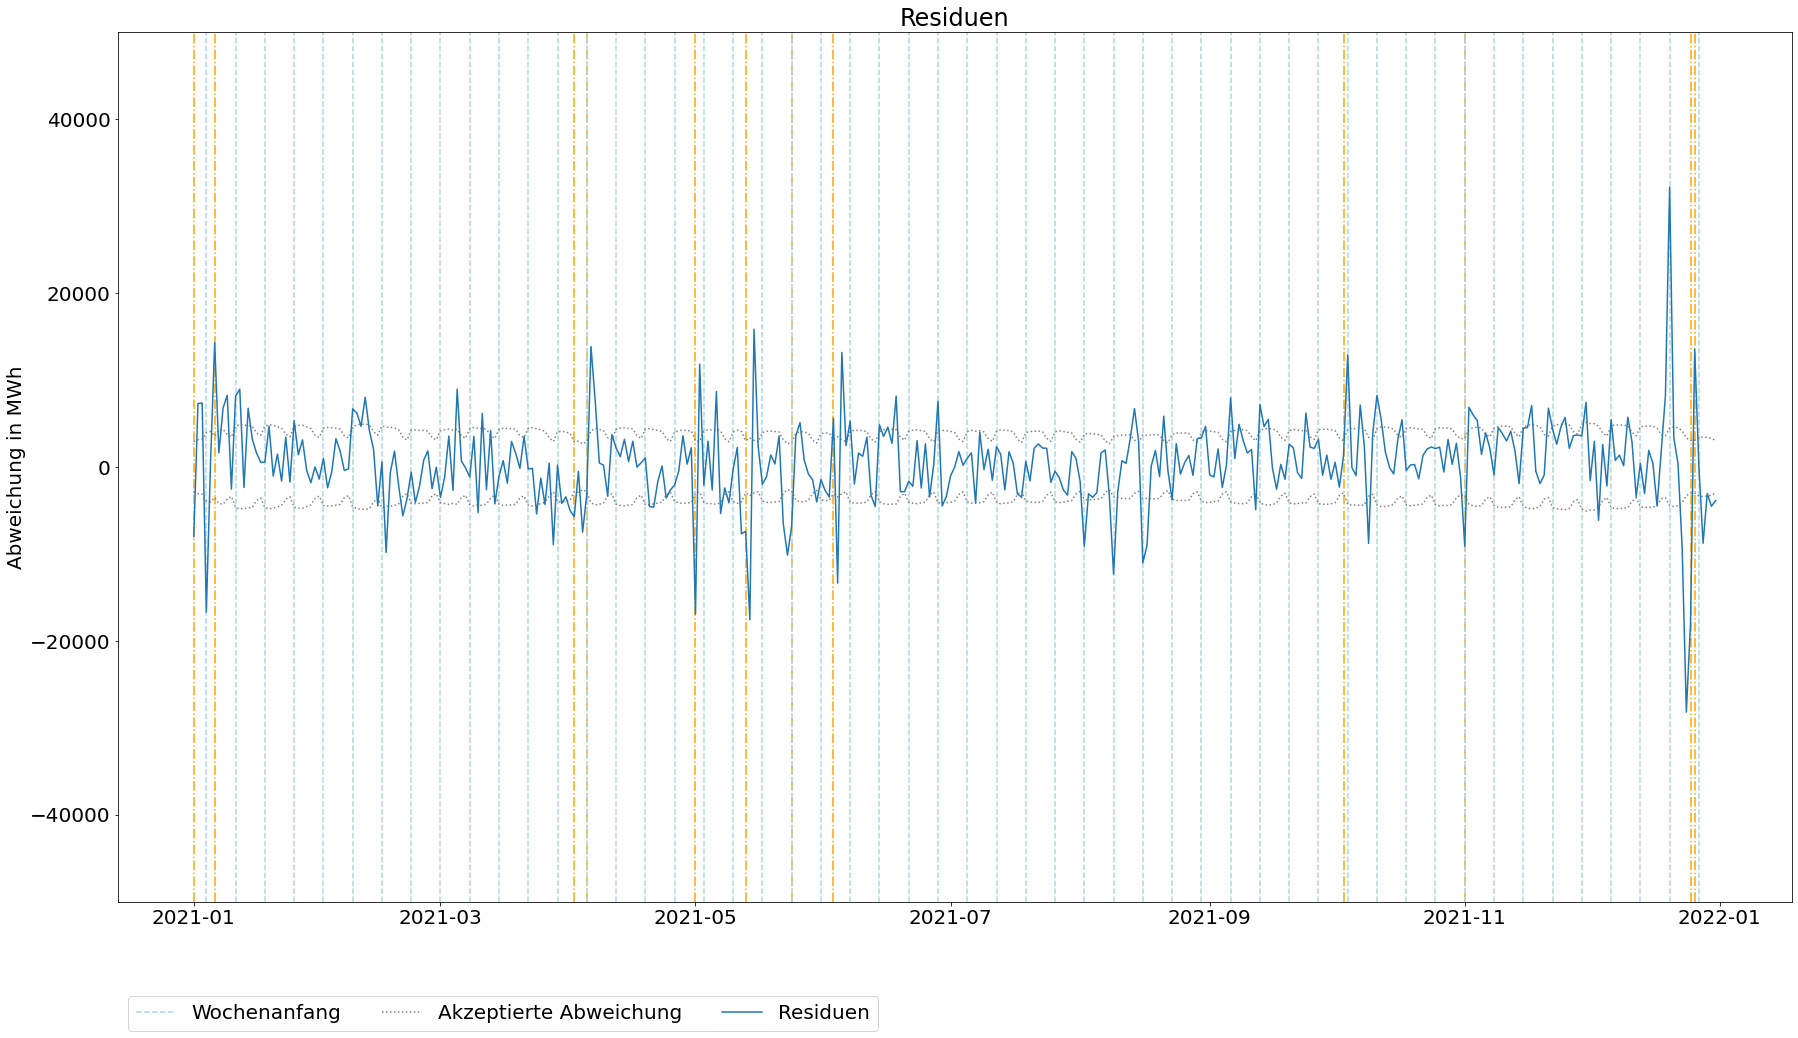

In [30]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics(y_true, preds, True, False, True, False)

## <font size="6">Verbesserung durch Merkmal für vergangene Feiertage (2)</font>

<font size="5">Wenn zusätzlich zum Indikator für Feiertage zwei zusätzliche Koeffizienten für jeweils die nächsten beiden Tage zum Modell hinzugefügt werden, dann lässt sich das Modell nicht verbessern. Im Vergleich zu den vorherigen Modellen verschlechtern sich auch AIC und Log-Likelihood wieder.</font>

In [16]:
#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Arbeitsfreie Tage erweitern
df_scaled["urlaubssaison"] = pd.read_csv("Daten/urlaubssaison_1.csv", index_col=0, parse_dates=True)
df_scaled.loc[df_scaled["urlaubssaison"] == 1, 'arbeitstag'] = 0

#Exogene Daten um Feiertag und Tage danach erweitern
df_scaled["feiertag"] = df_calendar["feiertag"].notna().astype(int)
df_scaled["feiertag_1"] = df_scaled["feiertag"].shift(1).fillna(0)
df_scaled["feiertag_2"] = df_scaled["feiertag"].shift(2).fillna(0)

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1","feiertag_2"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1","feiertag_2"]]["2021-01-01":]

exog = exog_train.append(exog_test)

In [17]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False)

#Vorhersage invers-skalieren
scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")
preds = pd.DataFrame(data=scaler_target.inverse_transform(scaled_preds.values.reshape(-1, 1)), columns=["vorhergesagt"], index=pd.date_range('01/01/2021', periods=365, freq='D')).squeeze()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4621.884
Date:                           Thu, 03 Feb 2022   AIC                          -9215.769
Time:                                   22:26:51   BIC                          -9133.917
Sample:                               01-01-2015   HQIC                         -9186.087
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2292      0.002    101.048      0.000       0.225       0.234
temperatur     0.0080      0.013      0.635

      Vorhersage
R2           1.0
MAE       3519.0
MSE   25980606.0
RMSE      5097.1
                
MAPE       2.0 %


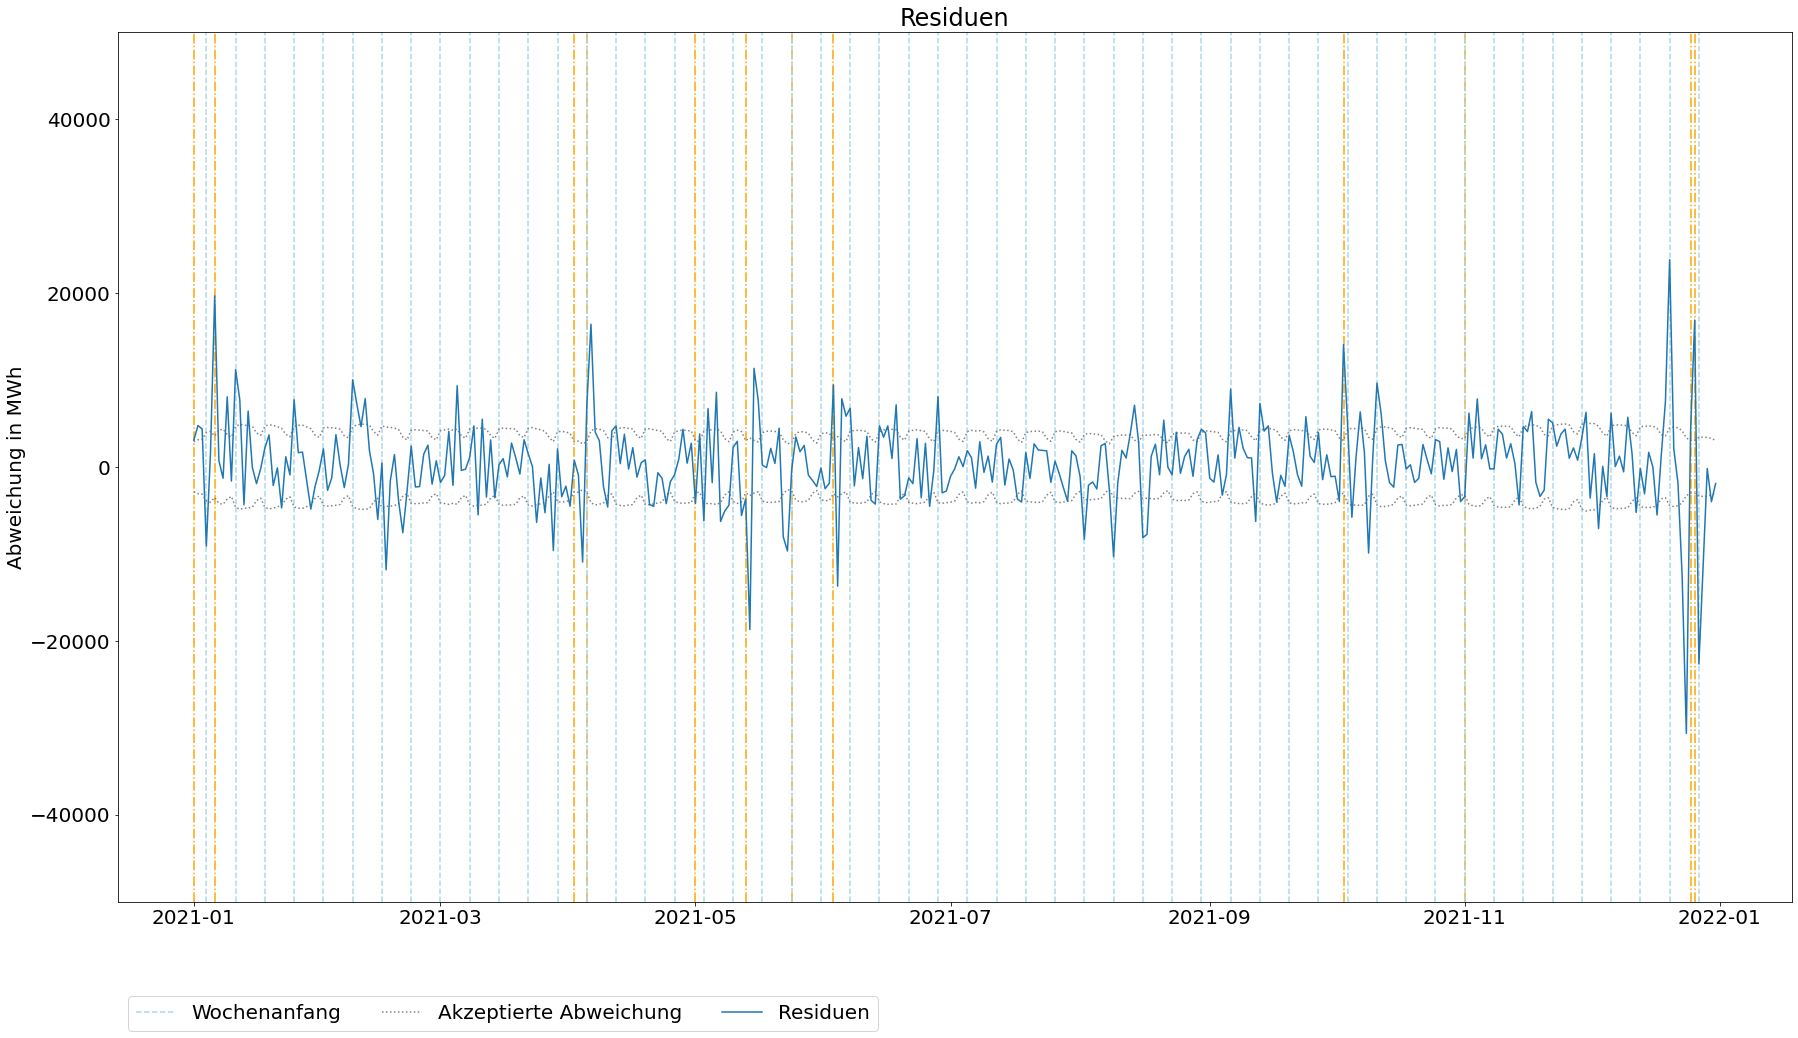

In [18]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics(y_true, preds, True, False, True, False)

## <font size="6">Verbesserung durch Merkmal für vergangene Feiertage (7)</font>

<font size="5">Das Modell lässt sich auch mit einem zusätzlichen Ausgleichskoeffizienten für den siebten Tag nach einem Feiertag nicht mehr verbessern.</font>

In [19]:
#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Arbeitsfreie Tage erweitern
df_scaled["urlaubssaison"] = pd.read_csv("Daten/urlaubssaison_1.csv", index_col=0, parse_dates=True)
df_scaled.loc[df_scaled["urlaubssaison"] == 1, 'arbeitstag'] = 0

#Exogene Daten um Feiertag und Tage danach erweitern
df_scaled["feiertag"] = df_calendar["feiertag"].notna().astype(int)
df_scaled["feiertag_1"] = df_scaled["feiertag"].shift(1).fillna(0)
df_scaled["feiertag_2"] = df_scaled["feiertag"].shift(2).fillna(0)
df_scaled["feiertag_7"] = df_scaled["feiertag"].shift(7).fillna(0)

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1","feiertag_2","feiertag_7"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1","feiertag_2","feiertag_7"]]["2021-01-01":]

exog = exog_train.append(exog_test)

In [20]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False)

#Vorhersage invers-skalieren
scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")
preds = pd.DataFrame(data=scaler_target.inverse_transform(scaled_preds.values.reshape(-1, 1)), columns=["vorhergesagt"], index=pd.date_range('01/01/2021', periods=365, freq='D')).squeeze()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4636.493
Date:                           Thu, 03 Feb 2022   AIC                          -9242.986
Time:                                   22:27:03   BIC                          -9155.287
Sample:                               01-01-2015   HQIC                         -9211.184
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2156      0.002     94.311      0.000       0.211       0.220
temperatur    -0.0404      0.013     -3.088

      Vorhersage
R2           1.0
MAE       3471.5
MSE   25663303.2
RMSE      5065.9
                
MAPE       2.0 %


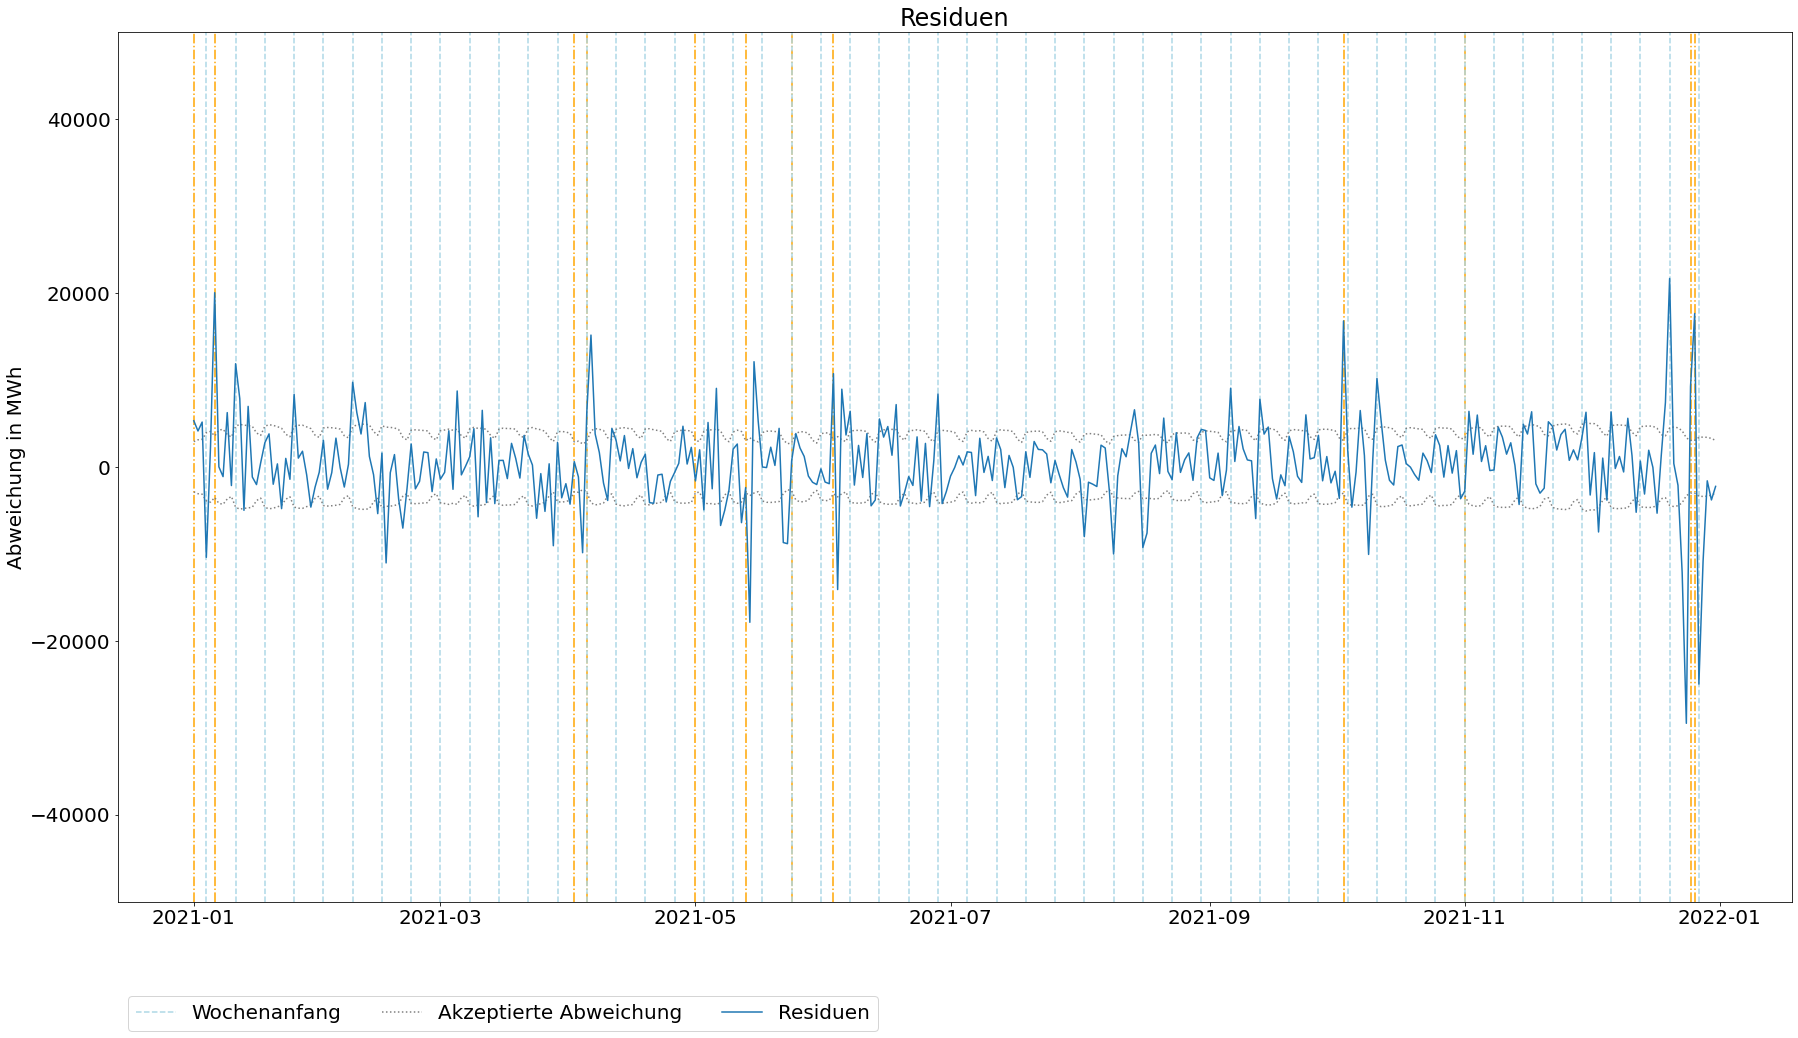

In [21]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics(y_true, preds, True, False, True, False)

## <font size="6">Verbesserung durch Merkmal für vergangene Feiertage (14)</font>

<font size="5">Letztlich wird noch ein Ausgleichskoeffizient für den vierzehnten Tag nach einem Feiertag hinzugefügt. Auch hierdurch ist keine weitere Verbesserung zu erzielen.</font>

In [22]:
#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Arbeitsfreie Tage erweitern
df_scaled["urlaubssaison"] = pd.read_csv("Daten/urlaubssaison_1.csv", index_col=0, parse_dates=True)
df_scaled.loc[df_scaled["urlaubssaison"] == 1, 'arbeitstag'] = 0

#Exogene Daten um Feiertag und Tage danach erweitern
df_scaled["feiertag"] = df_calendar["feiertag"].notna().astype(int)
df_scaled["feiertag_1"] = df_scaled["feiertag"].shift(1).fillna(0)
df_scaled["feiertag_2"] = df_scaled["feiertag"].shift(2).fillna(0)
df_scaled["feiertag_7"] = df_scaled["feiertag"].shift(7).fillna(0)
df_scaled["feiertag_14"] = df_scaled["feiertag"].shift(14).fillna(0)

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1","feiertag_2","feiertag_7","feiertag_14"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag","temperatur","feiertag","feiertag_1","feiertag_2","feiertag_7","feiertag_14"]]["2021-01-01":]

exog = exog_train.append(exog_test)

In [23]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False)

#Vorhersage invers-skalieren
scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")
preds = pd.DataFrame(data=scaler_target.inverse_transform(scaled_preds.values.reshape(-1, 1)), columns=["vorhergesagt"], index=pd.date_range('01/01/2021', periods=365, freq='D')).squeeze()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4652.339
Date:                           Thu, 03 Feb 2022   AIC                          -9272.679
Time:                                   22:27:16   BIC                          -9179.133
Sample:                               01-01-2015   HQIC                         -9238.756
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
arbeitstag      0.2090      0.002     90.261      0.000       0.204       0.214
temperatur     -0.0433      0.013     -3

      Vorhersage
R2           1.0
MAE       3496.4
MSE   26123208.8
RMSE      5111.1
                
MAPE       2.0 %


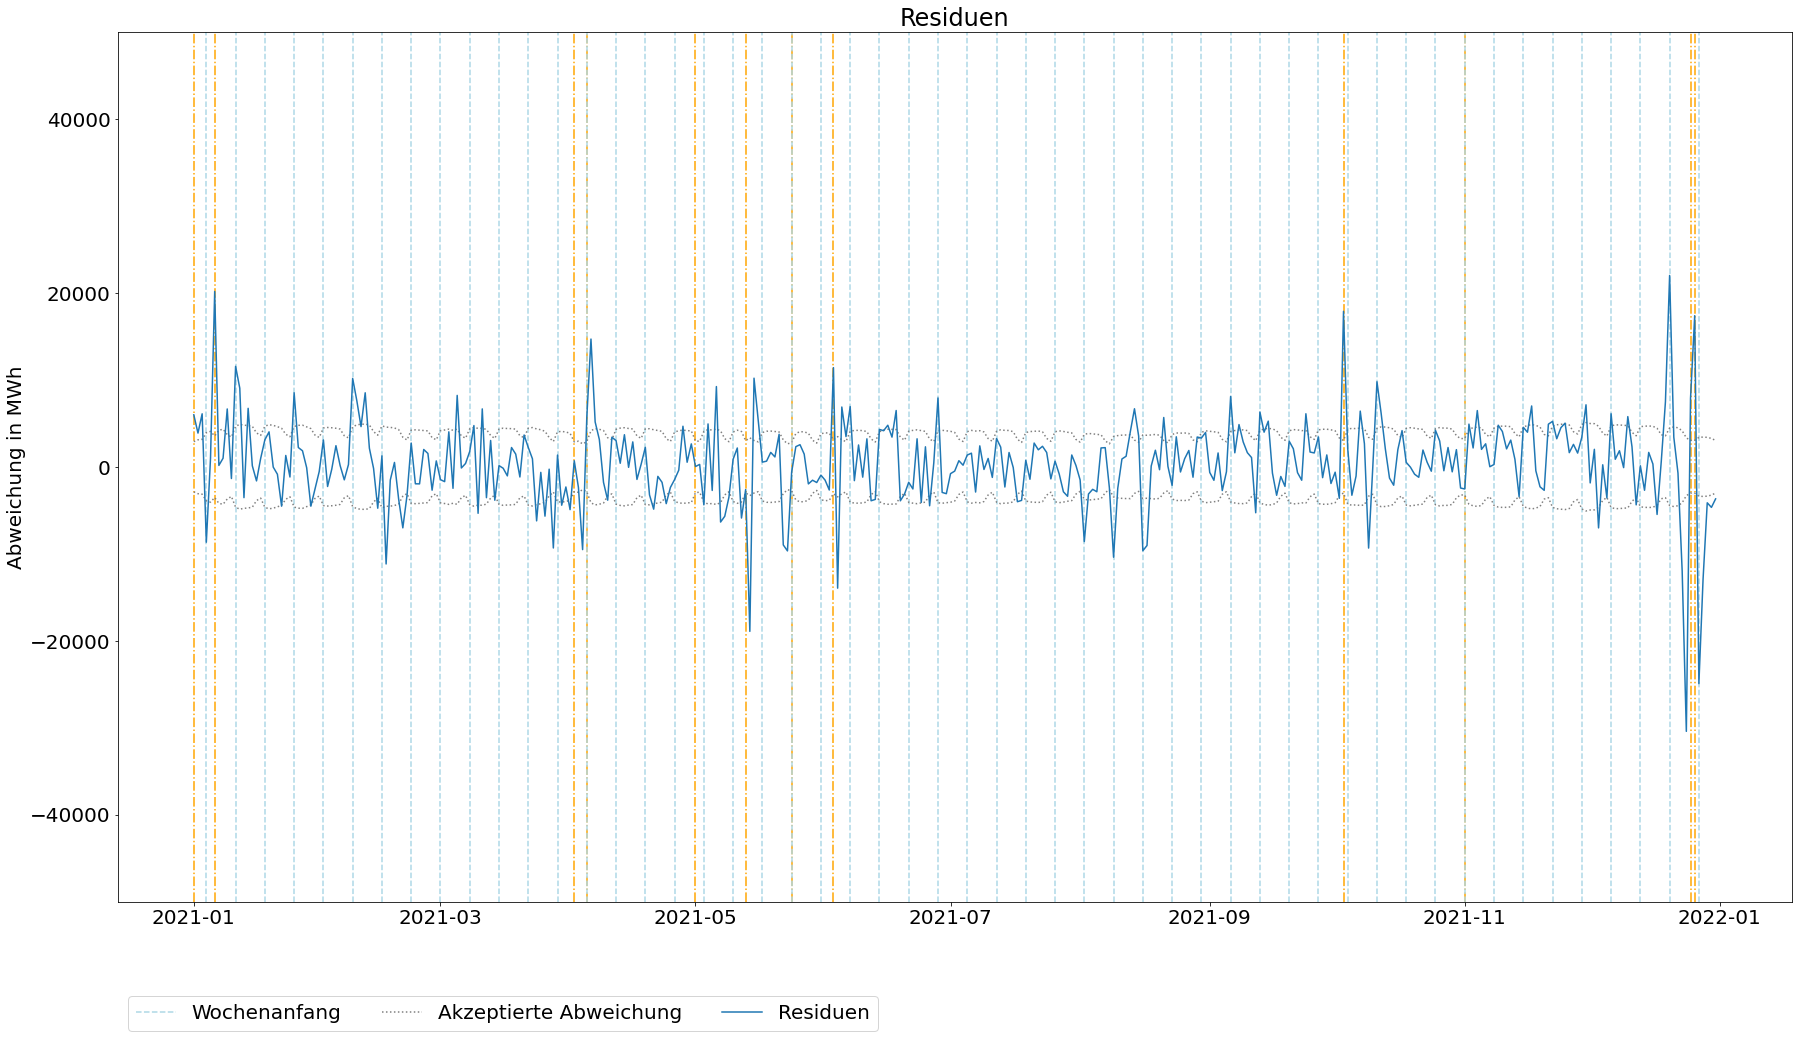

In [24]:
#Feiertage einzeichnen
for date in df_calendar["2021-01-01":][df_calendar["feiertag"].isna() == False].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="orange", linestyle="-.")

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics(y_true, preds, True, False, True, False)

# <font size="7">Ergebnis</font>

<font size="5">Stellenweise lässt sich das ARIMA-Modell durch die Ausgleichskoeffizienten verbessern, die Verbesserungen sind allerdings gering ausgeprägt und führen teilweise auch zu Überanpassungen. Ein wesentliches Problem ist, dass es nur etwa 30 Feiertage mit dem entsprechenden Problem in den Daten gibt. Bei insgesamt 2.557 Datensätzen sind daher sehr wenig Beispieldaten vorhanden, anhand derer der Algorithmus Daten generalisieren kann. Warum auf Oversampling verzichtet wird, ist in der Ausarbeitung genauer dargestellt. Vereinfacht gesagt lässt sich die Zeitreihe nicht ohne weiteres durch zusätzliche Beobachtungen erweitern, ohne das Wesen und den Verlauf der Zeitreihe zu ändern (Saisonalitäten, Autokorrelationen, Zusammenhänge mit anderen Merkmalen etc.). Unabhängig davon tritt das Problem nicht bei allen Feiertagen auf, folgt beispielsweise ein arbeitsfreier Tag auf den Feiertag ist das Problem sehr viel geringer, hier wären dann Ausgleichskoeffizienten für die Ausgleichskoeffizienten nötig. Der Grundgedankt, alle möglichen Sonderfälle durch eigene Koeffizienten abzudecken, widerspricht allerdings dem Grundgedanken des maschinellen Lernens: Der Generalisierung von Informationen aus vorhandenen Daten. Weiterhin ist zu erwähnen, dass das Modell sowohl die Baseline als auch das Erfolgskriterium bereits (mit Abstand) schlagen kann. Aus diesen Gründen wird vom Einsatz der hier beschriebenen Merkmale abgesehen.</font>